# **Exploring Topic Clusters in the #NBA Twittersphere**

# **Data Preprocessing & Latent Variable Unsupervised Machine Learning**

We will preprocess our dataset of tweets by using NLP tools from the `nltk` library, and we will also apply scaling to the data to prepare it for the machine learning models in a later part of the project.

Some NLP notes:

- Vectorizer
    - Look to using a **count vectorizer** in the NLP process - we are definitely interested in the pure *quantity* of word appearances, and we wouldn't want to do something like assigning "heavier weighting" to words that  appear less frequently (like TF-IDF)
    - We may want to use a high `min_df` (minimum document frequency) value so that we only capture words that are frequently used in the dataset
- You can specify what `vocabulary` you want when you use a vectorizer!  Pass in a list of all the terms you want to include in your vocabulary (provided they are actually in the corpus), e.g. `vocabulary = ['warriors', 'raptors', 'wolves', 'heat']`, or even a list of desired hashtags
    - Depending on vocabulary choice, this could greatly help in reducing dimensionality
    - **However, this is very restrictive!  We should let our machine learning models learn the clustering first with the full vocabulary**
    - Just something to think about for future analysis
- Hashtags
    - Drop "#NBA" after `.split(' ')` because it's in every tweet in our dataset!
    - Retain every other hashtag
- NBA player names
    - How do we deal with nicknames?  Should we even bother trying to convert them by creating some sort of dictionary? e.g. if we get a "beard" token which would likely be referring to James Harden, do we move the term frequencies from "beard" into those in "harden"?
    - Common names may lead to ambiguity, e.g. tokenizing "LeBron James" and "James Harden" will contribute twice to "james" even though we would want them separate
        - This points to using 2-grams, but that could significantly increase dimensionality.  We should try this project out with 1-grams first, and see what kind of results we obtain
- Typos
    - We can probably get rid of typos by using a high `min_df` in our vectorizer
- Custom content filtering
    - From browsing through the retrieved tweets, there is a lot of content about sports betting.  If we want to extract something like NBA-related opinions, we may want to put betting terminology/hashtags in our stop words list so that they are not included in our features.  This is *a posteriori* analysis and would be iterative (check features, apply new stop words, repeat)

We will also employ latent variable machine learning models.  These are a class of unsupervised machine learning models that find lower-dimensional representations (latent variables) of high-dimensional data.  In the context of natural language processing (NLP), these latent variables can be thought of as topics that are comprised of a set of words that are associated with each other.  We will look into three latent variable learning methods to help understand our data:

- principal component analysis (PCA)
- t-distributed stochastic neighbour embedding (t-SNE)
- latent Dirichlet allocation (LDA) topic modelling

The reason why data preprocessing and latent variable learning have been put in the same notebook is that the count vectorizer created in the preprocessing steps is required for LDA topic modelling visualizations.  Ideally we could pickle that count vectorizer variable for it could be loaded into another notebook, but the count vectorizer takes in a tokenizer function as a parameter, and the tokenizer used in this notebook is a custom-defined function, which cannot be pickled.

Let's import the packages we will need, and also read in the cleaned dataset from the previous section of this project.

In [1]:
# the data science triple threat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# to construct the custom tokenizer
from string import punctuation # a string of various punctuation marks
import nltk # for stopwords and the WordNet lemmatizer
nltk.download('stopwords') # need internet connection

# count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# to pickle the final list of stopwords
import pickle

# for creating word clouds
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

# for scaling data
from sklearn.preprocessing import MaxAbsScaler

# latent variable learning methods - PCA & LDA topic modelling
from sklearn.decomposition import PCA, LatentDirichletAllocation

# t-distributed stochastic neighbour embedding (t-SNE)
from sklearn.manifold import TSNE

# LDA topic modelling visualization
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# read in the cleaned master dataset
df = pd.read_csv('data/master_clean.csv')
df

,created_at,followers_count,friends_count,handle,hashtags,retweet,symbols,tweet,tweet_id,user_mentions,created_at_date,created_at_hour,created_at_dayofweek,created_at_dayofyear
0,2020-03-10 09:00:01-05:00,9672,664,RotoCurve,"[{'text': 'NBA', 'indices': [19, 23]}]",0,[],"The ""In The Paint"" #NBA Podcast returns with @...",1237377674298814464,"[{'screen_name': 'APfeifer24', 'name': 'Adam P...",2020-03-10,9,1,70
1,2020-03-10 09:00:11-05:00,71775,70998,RainmanPicks,"[{'text': 'NBA', 'indices': [115, 119]}]",0,[],Won't find anyone more consistent than us!\n\n...,1237377717756211200,[],2020-03-10,9,1,70
2,2020-03-10 09:00:28-05:00,3955,180,SimWorld4K,"[{'text': 'SeeTheGameBeTheGame', 'indices': [5...",0,[],More NBA news &amp; action! 👇 https://t.co/hhN...,1237377788535083008,[],2020-03-10,9,1,70
3,2020-03-10 09:00:29-05:00,2656,1509,bettheprop,[],1,[],1.5u - Russell Westbrook o45.5 pts+rbs+asts -1...,1237377792867815424,"[{'screen_name': 'PropBetGuy', 'name': 'Prop B...",2020-03-10,9,1,70
4,2020-03-10 09:00:32-05:00,157,332,WattersonDad,"[{'text': 'NBA', 'indices': [120, 124]}]",1,[],Ernie Johnson &amp; Chris Webber trying to exp...,1237377801944260608,"[{'screen_name': 'TodayInSports3', 'name': '#T...",2020-03-10,9,1,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15405,2020-03-17 07:36:16-05:00,2629,3825,FullPressRadio,"[{'text': 'FPC', 'indices': [133, 137]}, {'tex...",0,[],NOW AIRING - @FPCRadioLIVE w/ @iglen31 and @md...,1239893314033332224,"[{'screen_name': 'FPCRadioLive', 'name': 'FPC ...",2020-03-17,7,1,77
15406,2020-03-17 07:36:50-05:00,36,54,FanLinkSportsHQ,"[{'text': 'NBA', 'indices': [38, 42]}, {'text'...",0,[],Fanlink Cares https://t.co/JhYqCyB2sn #NBA #ML...,1239893455230439424,[],2020-03-17,7,1,77
15407,2020-03-17 07:37:34-05:00,2092,1648,lifestylelocks,"[{'text': 'LIFESTYLELOCKS', 'indices': [14, 29...",0,[],Capping these #LIFESTYLELOCKS #CASHOUTDAILYISA...,1239893641440698368,[],2020-03-17,7,1,77
15408,2020-03-17 07:37:48-05:00,94,189,BryceCarstensen,"[{'text': 'nba', 'indices': [108, 112]}, {'tex...",0,[],NBA simulated playoffs. Day 2 lets keep this g...,1239893698000965632,[],2020-03-17,7,1,77


---

## **Data Preprocessing**

### **Tokenization**

I will now implement a custom tokenizer for Twitter.  Some points for consideration:

- We would not want to remove hashtags (#) or at-symbols (@) as these are integral parts of Twitter language
- I personally prefer lemmatization as opposed to stemming.  Having words converted to their lemma forms is more interpretable than the naive stemmed forms
- It would be nice to have a second parameter of extra stop words in our custom tokenizer function, but sklearn's `CountVectorizer()` function only takes in tokenizers that have one input (the string to be tokenized) and one output (a list of all the tokenized words in that string)
    - We won't hard-code stop words into our tokenizer function; instead, we will use the `stop_words` argument in the `CountVectorizer()` function later on

In [3]:
def twitter_tokenizer(s):
    '''
    A custom tokenizer for tweets.
    
    INPUTS
    s: any tweet as a string
    
    OUTPUTS
    words_list_final: a list of cleaned and lemmatized tokens from s
    '''
    
    # assert that s is of type str
    assert isinstance(s, str), 's must be of type str'
    
    # convert all letters in string s to lower case
    s = s.lower()
    
    # do not include the hash symbol or at symbol in the list of punctuation marks we want to remove
    # from the input string
    twitter_punctuation = punctuation.replace('#', '').replace('@', '')
    twitter_punctuation += '’' # a style of apostrophe not already included in the punctuation string
    twitter_punctuation += '•' # bullet point
    
    # removal of punctuation marks from string
    for punctuation_mark in twitter_punctuation:
        s = s.replace(punctuation_mark, '')
    
    # replace line breaks with spaces
    s = s.replace('\n', ' ')
    
    # split the string at any spaces
    words_list = s.split(' ')
    
    # initiate lemmatizer
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    # empty list to append lemmatized words to
    words_list_final = list()
    
    # remove stop words, blank strings, and links
    for word in words_list:
        if (word != '') and (word[:4] != 'http'):
            words_list_final.append(word)
    
    # part-of-speech codes for the lemmatizer
    parts_of_speech = ['v', 'n', 'a', 'r']
    
    # applying all four part-of-speech lemmatizers to the list of words
    for part_of_speech in parts_of_speech:
        for i in range(len(words_list_final)):
            if (words_list_final[i][0] == '@') or (words_list_final[i][0] == '#'):
                continue
            else:
                words_list_final[i] = lemmatizer.lemmatize(words_list_final[i], pos=part_of_speech)
    
    return words_list_final

In [4]:
# random sample of a tweet from the dataset
sample_tweet = df['tweet'].sample().values[0]
print(sample_tweet, '\n\n')

# tokenization of random tweet
words_list_final = twitter_tokenizer(sample_tweet)
print(words_list_final)

KD could be back too... #NBA #NBAsuspended #NBATwitter https://t.co/a1mkntdfKc 


['kd', 'could', 'be', 'back', 'too', '#nba', '#nbasuspended', '#nbatwitter']


### **Vectorization**

As outlined earlier, I am looking to use a count vectorizer (as opposed to something like a TF-IDF vectorizer) because I am more interested in the quantity of word appearances without applying any kind of weighting.

In [5]:
%%time

# initiate count vectorizer
cv = CountVectorizer(
    min_df = 20, # should take care of typos, and also return only important words
    stop_words = nltk.corpus.stopwords.words('english'), # default NLTK English stop words
    lowercase = False, # already built into our tokenizer
    tokenizer = twitter_tokenizer
)

# fit and transform to obtain document-term matrix
dtm = cv.fit_transform(df['tweet'])

C:\Users\kevin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'far', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'thatll', 'wasnt', 'werent', 'win', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Wall time: 3.28 s


Note the warning message here regarding stop words.

In [6]:
dtm

<15410x1734 sparse matrix of type '<class 'numpy.int64'>'
	with 174281 stored elements in Compressed Sparse Row format>

Note that vectorization yields a very sparse matrix (compressed sparse row) - there are 174,821 stored elements in a matrix of size 15,410 x 1,734, so only 0.65% of the matrix contains non-zero elements!

In [7]:
# putting the vectorized text data into a dataframe
X = pd.DataFrame(data=dtm.toarray(), columns=np.array(cv.get_feature_names()))

We can now take a look at the sum of term frequencies for each word:

In [8]:
# sum of term frequencies for each word
X.sum().sort_values(ascending=False).head(60)

#nba                    14908
season                   2434
nba                      2352
#coronavirus             2286
game                     1932
#nhl                     1663
player                   1604
suspend                  1582
#mlb                     1516
get                      1472
play                     1342
#covid19                 1282
sport                    1274
amp                      1164
#nbatwitter              1125
go                       1025
coronavirus               965
test                      943
#nfl                      903
#basketball               869
cancel                    868
team                      832
#coronaviruspandemic      806
fan                       793
like                      777
positive                  748
gobert                    692
rudy                      687
time                      669
#sports                   659
day                       655
v                         590
win                       577
today     

- Again, the NBA **season** being **suspend**ed/**cancel**led due to **Rudy Gobert test**ing **positive** for **coronavirus** is the hottest topic
- The mentions of other non-basketball sports leagues (#nhl, #mlb, #nfl) could be coming from the sports betting or sports news accounts we discovered earlier.  These could also be coming from tweets about these other sports leagues and their (planned) actions/responses to the coronavirus outbreak
- I would have expected "lebron" or "jam" (the tokenized form of "james" using our `twitter_tokenizer()` function) to appear in this list, but neither are in the top 60!  This is likely due to the ongoing discussions about coronavirus and the league being suspended
- There are a lot of NBA- or basketball-related words that are redundant since we obtained all of these tweets by searching "#nba" (this is addressed in the next section)

Though tedious, it is also possible to look through the words manually to see what we might not want:

In [9]:
list(X.columns)

['#',
 '#1',
 '#2020',
 '#2k',
 '#2k20',
 '#2kcommunity',
 '#76ers',
 '#ad',
 '#adamsilver',
 '#adidas',
 '#afl',
 '#art',
 '#athlete',
 '#ballislife',
 '#baseball',
 '#basketball',
 '#basketballcards',
 '#bball',
 '#bet',
 '#bethefight',
 '#bets',
 '#betsystem',
 '#betting',
 '#bettingexpert',
 '#bettingpicks',
 '#bettingtips',
 '#bitcoin',
 '#blazers',
 '#bleedgreen',
 '#bookie',
 '#boston',
 '#bostonceltics',
 '#bovada',
 '#boxing',
 '#breaking',
 '#breakingnews',
 '#brooklyn',
 '#brooklynnets',
 '#bucks',
 '#bulls',
 '#bullsnation',
 '#business',
 '#bw',
 '#canceleverything',
 '#capper',
 '#cash',
 '#cashoutdailyisamflifestyle',
 '#casino',
 '#cavs',
 '#cbb',
 '#cdc',
 '#celtics',
 '#cfb',
 '#championsleague',
 '#chicago',
 '#chicagobulls',
 '#china',
 '#cleveland',
 '#clippernation',
 '#clippers',
 '#cnn',
 '#cnnmoneyinvest',
 '#coachella',
 '#codes',
 '#codvid19',
 '#collect',
 '#collegebasketball',
 '#corona',
 '#coronaoutbreak',
 '#coronapocalypse',
 '#coronapocolypse',
 '#coro

and add those to our stop words.  However, let's move along for now, and work with the full dataset.

In [10]:
# word of choice
term = 'pick'

# random return of a tweet that contains the above word
df['tweet'][pd.Series(X[term][X[term] > 0].index).sample().values[0]]

'‘3/11/2020 Free Picks Podcast Full Show Wednesday With Tony T and Cameron Ross’ on #NBA #NBAPicks #FreePicks #SportsPicks #SportsBetting https://t.co/3Xzg1j8Huj'

### **Extra Stop Words & Re-Vectorizing**

We used NLTK's default stop words list `nltk.corpus.stopwords.words()` in count vectorizing our text data.  However, by looking at the list of summed term frequencies for each word feature, we can make note of some extra stop words we should add to our vectorizer:

- Every tweet in our dataset contains "#nba" since this was our search term
- Ampersands are represented as "&amp\;" - after dropping the punctuation symbols, we are left with "amp"
    - Though "amp" is indeed a valid word - e.g. abbreviation of "amplifier", to "amp", or to be "amped" - I would imagine that this usage is quite rare in the world of the NBA, and thus we should be okay to include it as a stop word
- Terms like "#nbatwitter", "nba", "#basketball", and "basketball" are irrelevant since we obtained these tweets by searching "#nba"

In [11]:
# create NLTK English stop words list
stopwords = nltk.corpus.stopwords.words('english')

# add extra stop words
stopwords += [
    '#nba', # the search term we used to construct our corpus
    'amp', # ampersand is denoted by "&amp;"
    '#nbatwitter', '#basketball', 'nba', 'basketball', # generic nba/basketball terms
#     '#nhl', 'nhl', '#nfl', 'nfl', '#mlb', 'mlb', '#sports', # other major sports leagues
#     '#bet', '#betting', '#bettingexpert', '#bettingpicks', '#bettingtips', # sports betting
#     '#sportsbetting', '#sportsbettingadvice', 'bet', 'betting', '#dfs', # sports betting
#     '#draftkings', '#gamblingtwitter', '#fanduel', '#sportspicks', 'pick' # sports betting
]

We can also add the stop words from the warning message we got earlier.

In [12]:
stopwords += ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'far', 'hadnt',
              'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant',
              'shes', 'shouldnt', 'shouldve', 'thatll', 'wasnt', 'werent', 'win',
              'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve']

Let's now pickle this final stopwords variable as we will need it later on in this project.

In [13]:
with open('stopwords.pickle', 'wb') as f:
    pickle.dump(stopwords, f)

Now we can re-run the count vectorization.

In [14]:
%%time

# initiate count vectorizer
cv_final = CountVectorizer(
    min_df = 20, # should take care of typos, and also return only important words
    stop_words = stopwords, # NLTK English stop words plus the extra ones we added
    lowercase = False, # already built into our tokenizer
    tokenizer = twitter_tokenizer
)

# fit and transform to obtain document-term matrix
dtm = cv_final.fit_transform(df['tweet'])

Wall time: 3.66 s


In [15]:
# putting the vectorized text data into a dataframe
X = pd.DataFrame(data=dtm.toarray(), columns=np.array(cv_final.get_feature_names()))

# shape check
print(f'{X.shape[0]} tweets')
print(f'{X.shape[1]} features')

15410 tweets
1713 features


In [16]:
# sum of term frequencies for each word
sum_tf = X.sum().sort_values(ascending=False).head(60)
sum_tf

season                  2434
#coronavirus            2286
game                    1932
#nhl                    1663
player                  1604
suspend                 1582
#mlb                    1516
get                     1472
play                    1342
#covid19                1282
sport                   1274
go                      1025
coronavirus              965
test                     943
#nfl                     903
cancel                   868
team                     832
#coronaviruspandemic     806
fan                      793
like                     777
positive                 748
gobert                   692
rudy                     687
time                     669
#sports                  659
day                      655
v                        590
today                    576
league                   567
take                     562
make                     561
back                     559
follow                   558
#ncaa                    543
last          

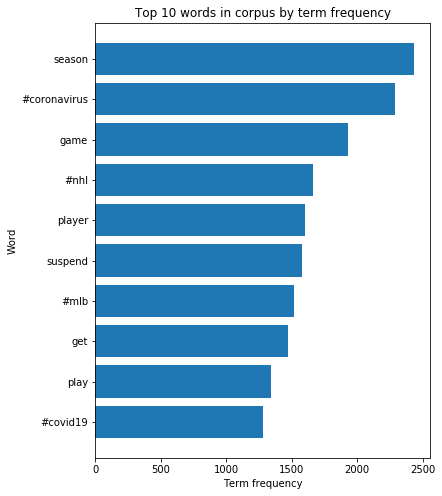

In [17]:
top_n_words = 10
plt.figure(figsize=(6,8))
plt.barh(sum_tf.index[:top_n_words][::-1], sum_tf.values[:top_n_words][::-1])
plt.title(f'Top {top_n_words} words in corpus by term frequency')
plt.xlabel('Term frequency')
plt.ylabel('Word')
plt.show()

Let's now save this final document-term DataFrame as a .csv file.

In [18]:
%%time

# write final vectorized text dataframe to a .csv file
X.to_csv('data/X.csv', index=False)

C:\Users\kevin\AppData\Local\Continuum\anaconda3\lib\site-packages\s3fs\mapping.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping


Wall time: 20.5 s


### **Word Cloud**

Time for some cloud computing!

...

No, not that kind.  Let's put together a word cloud to visualize the term frequencies in our corpus.  We will use the Python `wordcloud` package, which will require using the `PIL` (Python imaging library) package.

In [19]:
# create a single string of all the tweets in the dataset, for the wordcloud
all_tweets = ' '.join(tweet for tweet in df['tweet'])

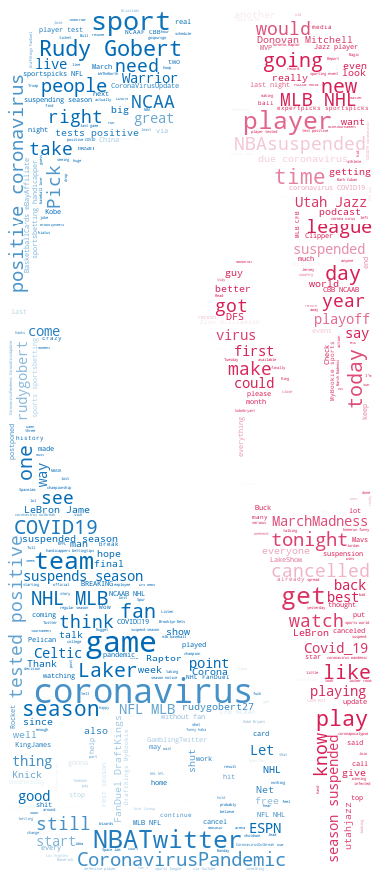

Wall time: 3.5 s


In [22]:
%%time

# open wordcloud image and convert to numpy array
mask = np.array(Image.open('images/nbalogo_large_crop.jpg'))

# create wordcloud properties and generate wordcloud using all of the tweets
wc = WordCloud(
    stopwords = stopwords + ['https', 'co'], # remove links
    background_color = 'white',
    max_words = 500,
    mask = mask,
    min_word_length = 3,
    random_state = 1,
    margin = 3
).generate(all_tweets)

image_colours = ImageColorGenerator(mask) # create colours from image
plt.figure(figsize=(10,16))
plt.imshow(wc.recolor(color_func=image_colours))
plt.axis('off')
plt.show()

Note that this is slightly different from the results we got from the count vectorization.  `WordCloud()` seems to have built-in punctuation removal that would get rid of the Twitter hashtags and mentions that we wanted to retain.  Thus, term frequencies for "#coronavirus" and "coronavirus" get added together.  Also, we see numerous duplicate words as well as what appears to be 2-grams.  The graphic still serves as a decent way to visualize the most common words in our tweets corpus.

In [23]:
# write word cloud to an image file
wc.to_file('images/nbalogo_large_crop_wordcloud.png');

### **Scaling the Data**

Since I plan to use distance-based machine learning models (k-means clustering, DBSCAN) in this project, we should scale our data.  However, because we used a count vectorizer on *tweets* (which are very short documents), the ranges of data won't be drastically different from column to column - tweets are only limited to 280 characters, which means you can only fit so many words into a tweet.

Let's find out the range of values in our vectorized dataset.  We know that the minimum possible value is 0, i.e. when a tweet does not contain a certain word.  So, let's look into the maximum word counts:

In [24]:
X.max().max()

9

The values in our vectorized dataset thus range from 0-9, so scaling might not even be necessary.  However, in general, having training data scaled can help machine learning models converge to solutions faster.  I am still inclined to scale our data, just to be on the safe/conservative side.

Recall that our dataset is very sparse.  Per the [scikit-learn preprocessing package documentation](https://scikit-learn.org/stable/modules/preprocessing.html), the `MaxAbsScaler` is the recommended scaler for sparse data as it preserves sparsity.  Let's go ahead and use this scaler to scale our data.

In [25]:
# max-abs scaler
scaler = MaxAbsScaler().fit(X)
X_s = scaler.transform(X)

In [26]:
# convert scaled data from numpy array to dataframe
X_s = pd.DataFrame(data=X_s, columns=X.columns)

Let's see what the `MaxAbsScaler` has actually done:

In [27]:
print('"lebron":\n')
print(X['lebron'].value_counts(), '\n') # vectorized data before scaling
print(X_s['lebron'].value_counts(), '\n\n\n') # vectorized data after scaling

print('"#coronavirus":\n')

print(X['#coronavirus'].value_counts(), '\n') # vectorized data before scaling
print(X_s['#coronavirus'].value_counts()) # vectorized data after scaling

"lebron":

0    15075
1      319
2       16
Name: lebron, dtype: int64 

0.0    15075
0.5      319
1.0       16
Name: lebron, dtype: int64 



"#coronavirus":

0    13151
1     2235
2       22
4        1
3        1
Name: #coronavirus, dtype: int64 

0.00    13151
0.25     2235
0.50       22
1.00        1
0.75        1
Name: #coronavirus, dtype: int64


The `MaxAbsScaler` has transformed each data into a range from 0 to 1.

Let's now save this scaled data to a .csv file as we will need it in the machine learning portion of this project.

In [28]:
%%time

# write scaled vectorized data to .csv file
X_s.to_csv('data/X_s.csv', index=False)

Wall time: 15.6 s


---

## **Latent Variable Machine Learning**

### **Principal Component Analysis (PCA)**

We can apply PCA to our data, which discovers principal components (PCs) within the data.  Each principal component (PC) is a linear combination of features that explain some amount of variance in the data.  Because we have 1,713 features in our vectorized dataset, I would not expect there to be a select few PCs that explain a large amount of variance.

In the context of unsupervised learning with text data, PCA can be thought of as finding groups of words (features) that explain variance in a dataset.

In [29]:
%%time

pca = PCA(random_state=1).fit(X_s)
X_s_pca = pca.transform(X_s)

Wall time: 6.25 s


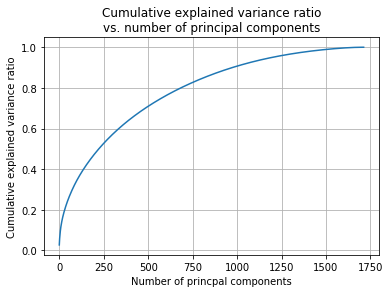

In [30]:
# plot cumulative sum of explained variance ratio
plt.figure()
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Cumulative explained variance ratio\nvs. number of principal components')
plt.xlabel('Number of princpal components')
plt.ylabel('Cumulative explained variance ratio')
plt.grid()
plt.show()

There is no clear "elbow" in the plot of cumulative explained variance ratio vs. number of principal components, meaning that there are indeed no select *few* PCs that explain a large portion of the variance.  However, it's worth noting that we can explain roughly 90% of the variance in our dataset by using 1,000 PCs, which would reduce dimensionality by nearly 750 features.

Let's now look into the features that comprise of some of the PCs:

In [31]:
pc_start = 1 # first PC to examine
pc_end = 19 # last PC to examine
top_n_components = 10 # top components from each PC

# display PCs, the words they comprise of, and the words' PCA weights
for pca_num in range(pc_start, pc_end+1):
    
    print(f'Principal component {pca_num}:')
    
    # organize features (words) and weights into a dataframe
    pca_components = pd.DataFrame({
        'token':X.columns,
        'PCA_weight':pca.components_[pca_num-1]
    })
    display(pca_components.sort_values('PCA_weight', ascending=False).head(top_n_components))
    
    print('\n')

Principal component 1:


,token,PCA_weight
300,#sports,0.400974
201,#mlb,0.303808
245,#nhl,0.268853
107,#fanduel,0.247468
311,#sportspicks,0.244903
237,#ncaaf,0.238850
51,#cfb,0.233776
243,#nfl,0.227967
145,#handicappers,0.219995
208,#mybookie,0.217682




Principal component 2:


,token,PCA_weight
201,#mlb,0.219752
14,#baseball,0.213909
90,#dk,0.213190
113,#fd,0.213020
127,#funny,0.212118
350,#usa,0.208516
249,#ny,0.207171
153,#homerun,0.205643
179,#lineup,0.205217
373,#wtf,0.205058




Principal component 3:


,token,PCA_weight
17,#bet,0.337466
21,#betting,0.239130
119,#football,0.206647
129,#gambling,0.200040
59,#cnn,0.197377
121,#foxnews,0.196732
252,#nytimes,0.191660
40,#business,0.189410
120,#forbes,0.186184
372,#wsj,0.186106




Principal component 4:


,token,PCA_weight
59,#cnn,0.172454
121,#foxnews,0.171566
252,#nytimes,0.165856
40,#business,0.160573
120,#forbes,0.160449
372,#wsj,0.160419
280,#reuters,0.160153
175,#latimes,0.160153
351,#usatoday,0.157512
277,#realdonaldtrump,0.157498




Principal component 5:


,token,PCA_weight
245,#nhl,0.537326
201,#mlb,0.425668
234,#ncaa,0.172445
202,#mls,0.165665
378,#xfl,0.160808
1467,sport,0.151211
243,#nfl,0.132587
72,#coronaviruspandemic,0.097463
210,#nascar,0.088404
78,#covid19,0.087358




Principal component 6:


,token,PCA_weight
300,#sports,0.633197
229,#nbasuspended,0.294130
289,#seethegamebethegame,0.124896
293,#simworldsports,0.123874
292,#simulation,0.100850
100,#esport,0.100236
159,#interactive,0.100236
356,#video,0.095073
72,#coronaviruspandemic,0.093807
291,#simleague,0.087630




Principal component 7:


,token,PCA_weight
15,#basketballcards,0.390032
96,#ebayaffiliate,0.353130
300,#sports,0.254608
1643,williamson,0.205407
1330,rc,0.189279
1229,panini,0.144873
1677,zion,0.108671
1297,prizm,0.107207
1381,rookie,0.102563
1213,optic,0.086903




Principal component 8:


,token,PCA_weight
229,#nbasuspended,0.691191
15,#basketballcards,0.373002
96,#ebayaffiliate,0.341521
1643,williamson,0.197877
1330,rc,0.184490
72,#coronaviruspandemic,0.133946
1229,panini,0.132972
1297,prizm,0.103546
1677,zion,0.102378
1381,rookie,0.097065




Principal component 9:


,token,PCA_weight
1271,positive,0.297982
1027,jazz,0.259257
1529,test,0.246416
1600,utah,0.208794
924,gobert,0.207427
732,coronavirus,0.205468
1386,rudy,0.191468
70,#coronavirus,0.189271
162,#jazz,0.165152
1259,player,0.162012




Principal component 10:


,token,PCA_weight
1079,like,0.470241
842,everybody,0.279912
1361,reply,0.258101
1680,“ifb”,0.243503
1586,tweet,0.229454
885,follow,0.185918
300,#sports,0.163257
221,#nbafollowtrains,0.141869
1572,train,0.136618
1385,rt,0.134294




Principal component 11:


,token,PCA_weight
1079,like,0.330821
289,#seethegamebethegame,0.264816
293,#simworldsports,0.261572
292,#simulation,0.237531
100,#esport,0.235522
159,#interactive,0.235522
291,#simleague,0.203405
842,everybody,0.179561
1361,reply,0.167155
1680,“ifb”,0.157592




Principal component 12:


,token,PCA_weight
354,#vc,0.273635
214,#nba2k20lockercodes,0.265779
260,#pg13,0.260038
181,#lockercodes,0.250192
62,#codes,0.242529
209,#myteam #myteam #pinkdiamond,0.242529
285,#ronnie2k,0.237207
215,#nba2k20 #nba2k20myteam,0.236974
1681,⁠⁠⁠,0.233657
1095,lockercode,0.220626




Principal component 13:


,token,PCA_weight
354,#vc,0.165238
260,#pg13,0.155475
214,#nba2k20lockercodes,0.152924
300,#sports,0.151745
181,#lockercodes,0.147869
62,#codes,0.146119
209,#myteam #myteam #pinkdiamond,0.146119
215,#nba2k20 #nba2k20myteam,0.141932
285,#ronnie2k,0.141613
1681,⁠⁠⁠,0.140881




Principal component 14:


,token,PCA_weight
112,#fashion,0.311686
317,#style,0.298890
1022,item,0.295353
488,@poshmarkapp,0.292183
290,#shopmycloset,0.292183
272,#poshmark,0.291341
683,check,0.184588
1424,share,0.154813
107,#fanduel,0.120592
1002,im,0.118244




Principal component 15:


,token,PCA_weight
1027,jazz,0.187344
112,#fashion,0.180806
1022,item,0.174732
317,#style,0.172262
488,@poshmarkapp,0.168769
290,#shopmycloset,0.168769
272,#poshmark,0.168219
177,#lebronjames,0.153388
1600,utah,0.149307
1271,positive,0.140722




Principal component 16:


,token,PCA_weight
66,#corona,0.272759
311,#sportspicks,0.227247
72,#coronaviruspandemic,0.226020
304,#sportsbettingadvice,0.219342
335,#tomhanks,0.206680
124,#freepick,0.204490
104,#expertpick,0.174053
224,#nbapick,0.170204
103,#expertbettingadvice,0.168710
1197,odds,0.148590




Principal component 17:


,token,PCA_weight
87,#dfs,0.345065
107,#fanduel,0.313669
92,#draftkings,0.165753
66,#corona,0.164371
1560,tonight,0.153342
219,#nbadfs,0.138808
335,#tomhanks,0.133356
72,#coronaviruspandemic,0.132311
64,#collect,0.112594
327,#thehobby,0.105904




Principal component 18:


,token,PCA_weight
64,#collect,0.342215
327,#thehobby,0.335203
243,#nfl,0.284163
942,gtgt,0.246504
486,@paniniamerica,0.229680
1229,panini,0.198584
381,#zionwilliamson,0.158230
66,#corona,0.156994
366,#whodoyoucollect,0.137004
1235,past,0.125319




Principal component 19:


,token,PCA_weight
360,#warriors,0.635702
93,#dubnation,0.294052
66,#corona,0.254726
87,#dfs,0.215649
107,#fanduel,0.215258
58,#clippers,0.184466
92,#draftkings,0.111489
1560,tonight,0.095479
219,#nbadfs,0.094612
136,#goldenstate,0.089460


The above output shows the features that comprise of each PC, and their associated weights.  We can identify some kinds of groupings here:

1. #sports, #mlb, #nhl, #fanduel, #sportspicks, #ncaaf, #cfb, #nfl
    - Related to daily fantasy sports ([FanDuel](https://www.fanduel.com/) is a sports betting provider)
2. #mlb, #baseball, #dk, #fd, #funny, #usa, #ny, #homerun
    - A baseball-oriented daily fantasy sports PC.  #dk refers to [DraftKings](https://www.draftkings.com/) (another sports betting provider), and #fd refers to FanDuel
3. #bet, #betting, #football, #gambling, #cnn, #foxnews, #nytimes
    - A curious grouping which includes both betting-related hashtags and major American news outlet hashtags
4. #cnn, #foxnews, #nytimes, #business, #forbes, #wsj, #latimes, #reuters
    - Hashtags for major American news outlets
5. #nhl, #mlb, #ncaa, #mls, #xfl, sport, #nfl, #coronaviruspandemic, #nascar, #covid19
    - Other major sports leagues, and their actions/plans amid the coronavirus breakout
6. #sports, #nbasuspended, #seethegamebethegame, #simworldsports, #simulation, #interactive, #esport
    - These actually come from the [@SimWorld4K](https://twitter.com/simworld4k) account
7. #basketballcards, #ebayaffiliate, #sports, williamson, rc, panini
    - Collectible sports cards, specifically NBA.  I do love me some paninis...
8. Same as 7
9. positive, jazz, test, utah, gobert, coronavirus, rudy
    - Regarding Rudy Gobert contracting the coronavirus
10. like, everybody, reply, "ifb", tweet, follow, #sports, #nbafollowtrains, train, rt
    - Likely coming from the kinds of tweets that get other users to follow each other
11. Same as 6
12. #vc, #nba2k20lockercodes, #pg13, #lockercodes, #codes, #myteam
    - A group that talks about the video game NBA 2K20.  I would imagine "#vc#" refers to Vince Carter, and "#pg13" surely refers to Paul George
13. Same as 12
14. #fashion, #style, item, @poshmarkapp, #shopmycloset #poshmark
    - Someone or some people tweeting at [@poshmarkapp](https://twitter.com/poshmarkapp) while including "#nba"?
15. Same as 14
16. #corona, #sportspicks, #coronaviruspandemic, #sportsbettingadvice, #tomhanks, #freepick, #expertpick, #nbapick, #expertbettingadvice
    - Some weird overlap between coronavirus, Tom Hanks (who contracted it), and sports betting
17. Same as 16
18. #collect, #thehobby, #nfl, gtgt, @paniniamerica, panini, #zionwilliamson
    - It turns out the "panini" from PC 7 refers to [@paniniamerica](https://twitter.com/paniniamerica), a collectibles company
19. #warriors, #dubnation, #corona, #dfs, #fanduel, #clippers
    - A grouping corresponding with the Golden State Warriors, although it's odd that "#clippers" (Los Angeles Clippers) shows up here too.  Maybe this relates to a game in which both teams faced off recently?

We could go on to analyze all 1,713 PCs and their features... but no.  While these aren't "clusters" in the unsupervised machine learning sense, these groupings could possibly help us understand clusters in our dataset.  Let's think about how many *unique* groups we have here, based on the above PCs:

- Daily fantasy sports (DraftKings, FanDuel)
- Sports betting
- There could be a group that contains all of those hashtags for the major American news outlets
- One group for anything pertaining to collectibles
- The topic of Rudy Gobert contracting coronavirus will likely be its own group
- Other sports leagues deciding what to do amid the coronavirus outbreak
- Content from @SimWorld4K
- Tweets pertaining to NBA 2K20
- The group about fashion
- Golden State Warriors

We should also try to think about other groups that we did not discover in the first 20 PCs:

- There would most definitely be a group for LeBron James and the Los Angeles Lakers
- Thinking of other large franchises, New York Knicks-related tweets might appear as their own group

We might also think of there being separate groups for every single NBA team, but all teams might not be represented in the dataset for a number of reasons: 1. the Twitter API search function that was used to gather the dataset does not guarantee that all possible tweets are returned, 2. some franchises are relatively small, and 3. our dataset only includes two days of actual basketball being played (March 10 & 11) - some teams did not have games on either of these days!

The only way to understand *all* possible feature groupings in PCA is to go through each PC, which would be impractical.  **The main takeaway from this PCA section is that there *are* feature groupings in our dataset, which help us believe that we can discover well-defined clusters.**

I will opt to **not** reduce the dimensionality of my dataset through using PC-transformed data because I want to retain as much variance in our dataset as possible when we fit machine learning models.  We only did PCA here to find feature grouping patterns.  Another reason to not use PC-transformed data is that it sacrifices direct interpretability - instead of being able to say that a single word is associated with a certain cluster (in unsupervised learning), we would have to use the PCA weights/proportions to explain the association of each word.  Also, the vectorized text dataset we are working with is not too large (15,410 tweets & 1,713 features), so it is not completely necessary to find ways to reduce computation times.

### **T-distributed Stochastic Neighbour Embedding (t-SNE)**

However, we can take PC-transformed data and put it into the t-distributed stochastic neighbour embedding (t-SNE) algorithm to help us visualize our high-dimensional data.  t-SNE reduces a high-dimensional dataset into 2 or 3 dimensions.  Per the [scikit-learn t-SNE documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), it is recommended to first reduce the dimensionality of the data through PCA before passing it into `sklearn.manifold.TSNE()`, so let's do exactly that.

In [32]:
# obtaining the first 50 principal components from the scaled vectorized text data
pca = PCA(n_components=50, random_state=1).fit(X_s)
X_s_pca = pca.transform(X_s)

Let's now reduce our data to 2 dimensions.

In [33]:
%%time

# THIS CELL TAKES A FEW MINUTES TO RUN!

tsne = TSNE(n_components=2, random_state=1) # initiate t-SNE
X_s_tsne = tsne.fit_transform(X_s_pca) # transform the PCs from the scaled vectorized text data

Wall time: 3min


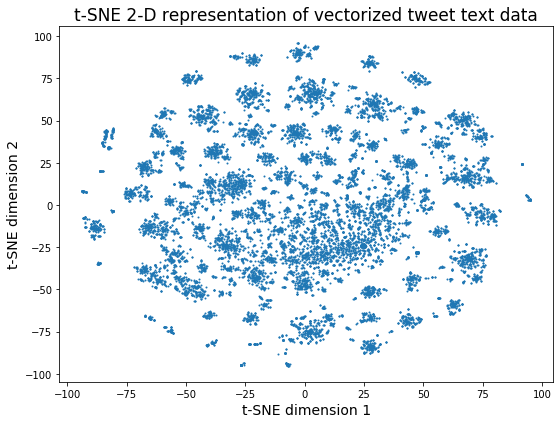

In [34]:
# visualizing t-SNE data
plt.figure(figsize=(8,6))
plt.scatter(X_s_tsne[:,0], X_s_tsne[:,1], s=1)
plt.title('t-SNE 2-D representation of vectorized tweet text data', size=17)
plt.xlabel('t-SNE dimension 1', size=14)
plt.ylabel('t-SNE dimension 2', size=14)
plt.tight_layout()
plt.savefig('tsne_2d.png')
plt.show()

We can indeed see that, through t-SNE, there are clustering patterns in our dataset!  Thus, it is worthwhile to continue discovering these clusters and what they represent.  I would say that there are **roughly 40 sufficiently large & well-defined clusters**.  We can also note the scattered, "noisy" data in the centre of the plot.

### **Latent Dirichlet Allocation (LDA) Topic Modelling**

The LDA method is widely used for topic modelling in text data.  However, one of its drawbacks is that the number of topics `n_components` must be specified prior to fitting it to data, so we should try to have a good educated guess of this value.  Luckily, we can start with the value of 40 that we estimated from analyzing t-SNE in the previous section.

#### First Iteration - 40 Topics

In [40]:
%%time

n_topics = 40 # number of topics

# instantiate and fit LDA
lda = LatentDirichletAllocation(
    random_state = 1,
    n_jobs = -1,
    n_components = n_topics
)
lda.fit(X) # fit LDA to UNSCALED document-term matrix

# generate LDA topic modelling visualization
lda_vis = pyLDAvis.sklearn.prepare(lda, dtm, cv_final)

# save visualization to .html file
pyLDAvis.save_html(lda_vis, f'lda_vis_01_-_{n_topics}_topics.html')

Wall time: 32.2 s


C:\Users\kevin\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


To view the visualization of the above LDA model, open the .html file that was generated above.  It is located in the same directory as this notebook.

This interactive visualization shows all of the topics that the LDA model found, and the words contained within each topic.  To see the words in each topic, you can: hover your cursor over the bubbles in the intertopic distance map, click the "Previous Topic" and/or "Next Topic" buttons to browse through each topic, or enter the topic number in the "Selected Topic:" field.  You can also hover your cursor over the words in the Top-30 Most Salient Terms to see which topics a word appears in.

The intertopic distance map on the left hand side of the visualization is, like t-SNE, a two-dimensional representation of our data, and each bubble represents one topic.  One aspect of the plot we should inspect is what this two-dimensional space (defined by PC1 and PC2) actually represents.  We can do this by inspecting the topics in each of the plot's *quadrants*, or by looking through each of the top 30 most salient terms and seeing where in the map they appear the most:

- **Bottom left** - Topics about the NBA suspending due to coronavirus, and the ensuing discussion of what the other major sports leagues should be doing
- **Upper left** - The most uninterpretable of the quadrants, with topics containing words like "people take would make right" (topic 3) and "season playoff play start think" (8)
    - Topic 21 is about the Toronto Raptors!  Nice!
- **Upper right** - Closer to PC2 we see a lot of team-specific topics: Los Angeles Lakers & LeBron James (15), Golden State Warriors (36), and the Boston Celtics (30).  Moving to the right, we start to see topics containing "#dfs" (daily fantasy sports) and "#gamblingtwitter" - all part of sports betting.  We also make note of topic 25, a very strongly-defined cluster about collectible basketball cards
- **Bottom right** - The most sparse quadrant, with the topic bubbles being quite small (low marginal topic distribution).  Topics 19 and 32 seem to be about sports betting

We notice that there is some overlap between topics in the intertopic distance map.  Let's identify the overlapping topics.  For any group of $n$ overlapping topics, we can look to subtracting $n-1$ from `n_components` in a second LDA model iteration to _hopefully_ force the model to collect the overlapping topics into one single topic.  The motivation for doing this is that we are trying _not_ to obtain granular topics - we want to see the most general topics that the model can find.  Also, it is (hopefully) easier to interpret a lesser number of topics.

- Topics 2, 4, 9 (3 total overlapping topics, so subtract 2 from `n_components`)
- 3, 8, 12, 13 (-3)
- 20, 24 (-1)
- 22, 31 (-1)
- 15, 30, 36 (-2)
- 26, 27, 28 (-2)
- 17, 25, 37 (-2)

Now let's look to creating a second LDA model that has less topics.  The number of topics we will input in the second iteration is $40-2-3-1-1-2-2-2=27$.

#### Second Iteration: 27 Topics

In [41]:
%%time

n_topics = 27

# instantiate and fit LDA
lda = LatentDirichletAllocation(
    random_state = 1,
    n_jobs = -1,
    n_components = n_topics
)
lda.fit(X) # fit LDA to UNSCALED document-term matrix

# generate LDA topic modelling visualization
lda_vis = pyLDAvis.sklearn.prepare(lda, dtm, cv_final)

# save visualization to .html file
pyLDAvis.save_html(lda_vis, f'lda_vis_02_-_{n_topics}_topics.html')

Wall time: 29.3 s


C:\Users\kevin\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


To view the visualization of the above LDA model, open the .html file that was generated above.  It is located in the same directory as this notebook.

In the 27-topic LDA model, the quadrants' _topics_ are similar to the 40-topic model, but are just in different positions on the map.  This is not an issue, as it just has to do with the PC1/PC2 polarity "choices" during the model fitting.

Let's continue to try to remove overlapping topics.

Overlapping topics:

- 2, 3 (-1)
- 4, 9 (-1)
- 5, 7, 13, 14 (-3)
- 8, 17, 18, 21, 26 (-4)

$27-1-1-3-4=18$ topics for third iteration

#### Third Iteration: 18 Topics

In [42]:
%%time

n_topics = 18

# instantiate and fit LDA
lda = LatentDirichletAllocation(
    random_state = 1,
    n_jobs = -1,
    n_components = n_topics
)
lda.fit(X) # fit LDA to UNSCALED document-term matrix

# generate LDA topic modelling visualization
lda_vis = pyLDAvis.sklearn.prepare(lda, dtm, cv_final)

# save visualization to .html file
pyLDAvis.save_html(lda_vis, f'lda_vis_03_-_{n_topics}_topics.html')

Wall time: 29.1 s


C:\Users\kevin\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


To view the visualization of the above LDA model, open the .html file that was generated above.  It is located in the same directory as this notebook.

In this 18-topic model, topics 6, 11, 14 and 16 are grouped together in the intertopic distance plot, but words-wise the topics are actually quite distinct from each other.  This leaves us with:

- 1, 3 (-1)
- 4, 8 (-1)

$18-1-1=16$ topics

#### Fourth (Final) Iteration: 16 Topics

In [43]:
%%time

n_topics = 16

# instantiate and fit LDA
lda = LatentDirichletAllocation(
    random_state = 1,
    n_jobs = -1,
    n_components = n_topics
)
lda.fit(X) # fit LDA to UNSCALED document-term matrix

# generate LDA topic modelling visualization
lda_vis = pyLDAvis.sklearn.prepare(lda, dtm, cv_final)

# save visualization to .html file
pyLDAvis.save_html(lda_vis, f'lda_vis_04_-_{n_topics}_topics.html')

Wall time: 28.5 s


C:\Users\kevin\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [44]:
# uncomment to view the visualization in this notebook, or open the .html file that was generated
# pyLDAvis.display(lda_vis)

After this final iteration, some of the topics still overlap in the intertopic distance map, but their actual subject matter is quite different:

- I'm not sure what topics 1 and 3 are about, but their respective relevant words are different from each other's.  **It's possible that these can be interpreted as noise in the data**
- Topic 4 is about the NBA season being suspended due to coronavirus, 5 is more specific to two of the Utah Jazz players who contracted it
- Topic 8 is about sports betting picks, 9 is about LeBron James and the Los Angeles Lakers, 12 is about the Golden State Warriors (and the Boston Celtics too?), and 15 is about the San Antonio Spurs

I want to make note that the evaluations we have done on the LDA iterations above were somewhat crude and non-scientific - all we did was check how human-interpretable the words in each topic were.  In the future, it would be very much worth exploring actual numerical metrics for LDA model evaluation.

To close out our dive into latent variable learning, let's try to summarize what all 16 of these LDA topics are about:

1. game, play, fan, go, year, would, get, back, see, etc. - ?
2. NHL, MLB, NCAA and discussions on if they will follow suit like the NBA in suspending their respective leagues
3. get, need, go, people, time, like, great, im, work, etc. - ?
4. The announcement of the NBA temporarily suspending their season
5. Rudy Gobert and Donovan Mitchell of the Utah Jazz testing positive for coronavirus (the first and third NBA players to test positive)
6. Tweets about a podcast, and the discussions about coronavirus
7. team, player, game, day, season, point, pt, etc. - ?
8. Sports betting stats/odds (most terms in this topic are numbers).  All teams that were mentioned in this topic played on March 10 and/or 11.
9. LeBron James / Los Angeles Lakers
10. #gamblingtwitter and sports betting picks
11. Daily fantasy sports (DraftKings and FanDuel)
12. Golden State Warriors (and Boston Celtics?  Both teams did not play each other around the time of these tweets)
13. Basketball collectible cards
14. Sports betting and... Donald Trump?
15. San Antonio Spurs and Dallas Mavericks (they played each other on March 10)
16. Sports betting including NFL, NHL, MLB, and NCAA baskestball

It is very encouraging that most of the LDA topics are discernable and distinct.

In the following section, we will explore the clustering types of unsupervised machine learning models, specifically k-means clustering and DBSCAN, to see if they produce similar results.